In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, GridSearchCV
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print('Train R2:\t' + str(round(r2(train_true_values, train_pred_values), 3)))
    print('Test R2:\t' + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [4]:
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
SUBMIT_DATASET_PATH = './sample_submission.csv'

### Загрузка данных <a class='anchor' id='load'>

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [8]:
train_df.shape[0], test_df.shape[0]

(10000, 5000)

### Приведение типов

In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA  

###  Распределение целевой переменной

In [11]:
train_df['Price'].mean(), train_df['Price'].median()

(214138.8573987389, 192269.64487934904)

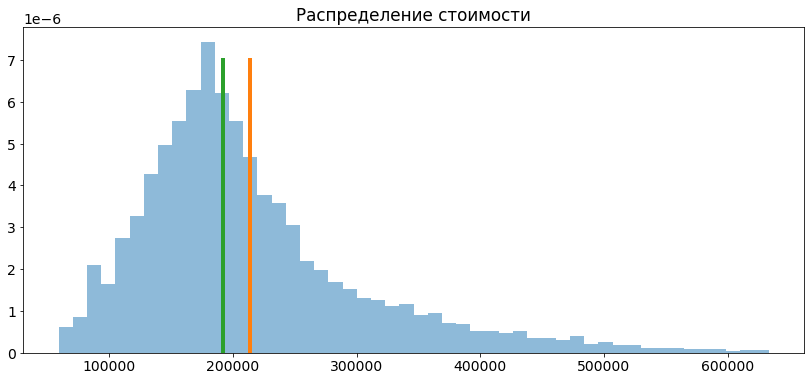

In [12]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()

plt.figure(figsize = (14, 6))
plt.hist(train_df['Price'], density=True, bins=50, alpha=0.5)

y = np.linspace(0, 0.000007, 2)
plt.plot([target_mean] * 2, y, linewidth=4)
plt.plot([target_median] * 2, y,linewidth=4)

plt.title('Распределение стоимости')
plt.show()

### Количественные переменные

In [13]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Категориальные переменные

In [14]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [15]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [16]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [17]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка пропусков и выбросов

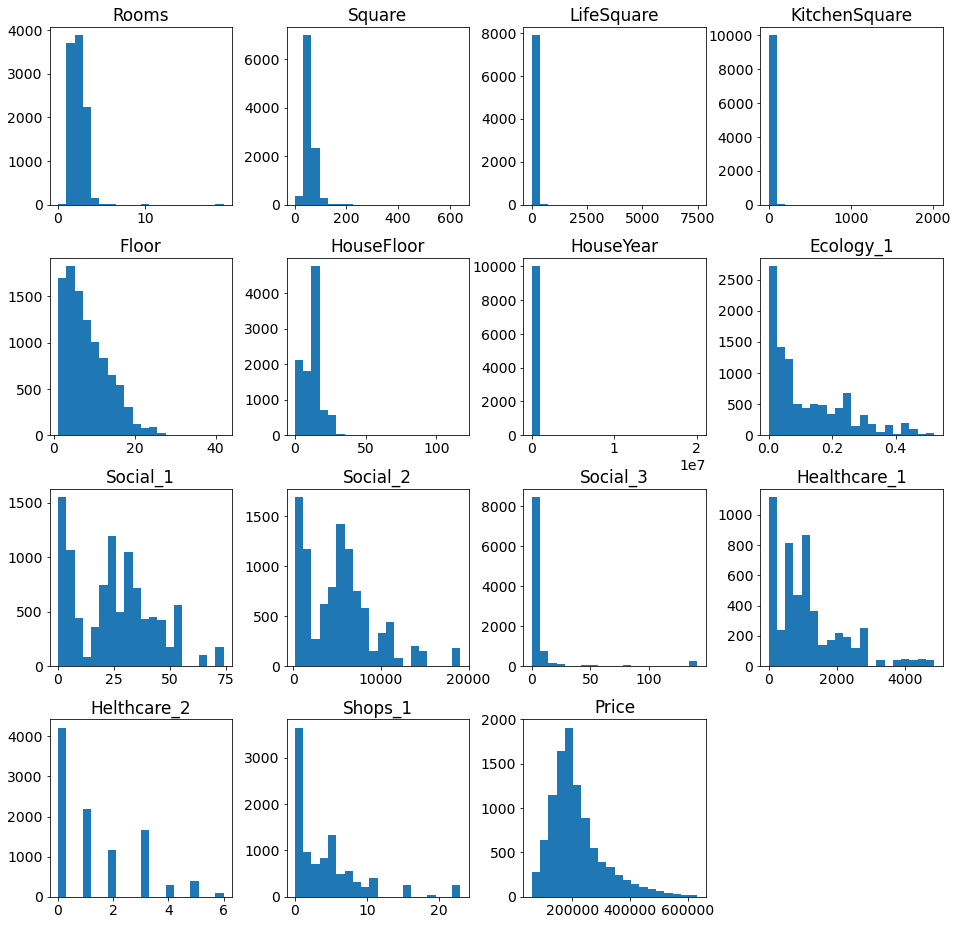

In [18]:
train_df.hist(figsize=(16, 16), bins=20, grid=False);

##### Rooms
Нормой будем считать количество комнат не более 5 и не менее 1

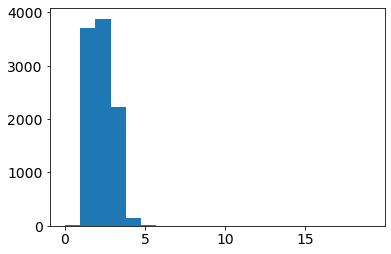

In [19]:
train_df['Rooms'].hist(bins=20, grid=False);

##### HouseYear

Нормой будем считать дома не старше 1938 года и не младше текущего

In [20]:
train_df.loc[train_df['HouseYear'] < 1938].shape

(55, 20)

##### Square, KitchenSquare, LifeSquare

In [21]:
train_df.loc[(train_df['KitchenSquare'] > 22) & (train_df['Square'] < 150)].shape

(38, 20)

Размер кухни не должен превышать 22кв.м при общей площади квартиры меньше 150кв

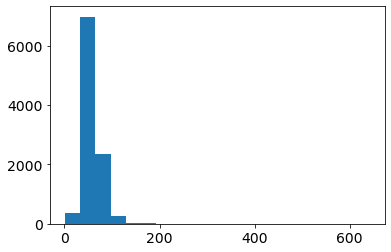

In [22]:
train_df['Square'].hist(bins=20, grid=False);

Нормой будем считать квартиру общей площадью не меньше 25 и не больше 200, остальные значения заменим на медиану

In [23]:
train_df.loc[train_df['LifeSquare'] > (train_df['Square'] * 0.8)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777
33,847,74,2.0,73.314975,74.131261,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863
34,7757,27,2.0,58.783661,55.441256,11.0,13,12.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,138396.984612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617
9965,6441,52,3.0,85.796885,85.305246,0.0,15,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B,204462.983720
9979,2201,6,1.0,40.043234,41.984322,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698


##### Floor, HouseFloor

In [24]:
train_df.loc[train_df['HouseFloor'] > 50]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
746,9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579
1678,78,30,2.0,65.773749,66.811789,1.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520
4657,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515


Этажность домов выше 50 заменим на медиану

In [25]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.246494
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
25,4521,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
9968,9920,1,3.0,86.487550,NaN,1.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,248248.935528
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,114878.830713
9975,4944,6,2.0,52.573133,NaN,1.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184


В ситуациях, когда этаж квартиры превышает этажность дома приравняем этажность к этажу квартиры

In [26]:
class DataPreprocessing:

    def __init__(self):
        self.medians = None
        
    def fit(self, X):    
        # Расчет медиан
        self.medians = X.median()
    
    def transform(self, X):

        # выбросы LifeSquare и Healthcare_1
        medians = X[['LifeSquare', 'Healthcare_1']].median()
        X[['LifeSquare', 'Healthcare_1']] = X[['LifeSquare', 'Healthcare_1']].fillna(medians)     
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 5), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 5, 'Rooms'] = self.medians['Rooms']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] > 50, 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] < X['Floor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] > 50, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] < X['Floor'], 'HouseFloor'] = X['Floor']
        
        # HouseYear
        current_year = datetime.now().year
        X['HouseYear_outlier'] = 0
        X.loc[(X['HouseYear'] > current_year) | (X['HouseYear'] < 1938), 'HouseYear_outlier'] = 1
                
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        X.loc[X['HouseYear'] < 1938, 'HouseYear'] = self.medians['HouseYear']
        
        # Square
        X['Square_outlier'] = 0
        X.loc[(X['Square'] > 200) | (X['Square'] < 25), 'Square_outlier'] = 1
        
        X.loc[(X['Square'] > 200) | (X['Square'] < 25), 'Square'] = self.medians['Square']
        
        # KitchenSquare
        X.loc[(X['KitchenSquare'] > 22) & (X['Square'] < 150), 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 5, 'KitchenSquare']  = self.medians['KitchenSquare']
        
        # LifeSquare
        coef_sq = (X['LifeSquare'].mean()) / (X['Square'].mean())
        
        X.loc[(X['LifeSquare'] > X['Square'] * 0.8), 'LifeSquare'] = X['Square'] * coef_sq
        X.loc[(X['LifeSquare'] < 30), 'LifeSquare'] = X['Square'] * coef_sq
            
        X.fillna(self.medians, inplace=True)
        
        return X

### 3. Построение новых признаков  <a class='anchor' id='feature'>

In [27]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})       
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
    
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1        
        X['DistrictSize'].fillna(5, inplace=True)      
        
        # More categorical features
        X = self.floor_to_cat(X)  
        X = self.year_to_cat(X)  
         # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 5, 10, 15, 20, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1950, 1970, 1990, 2010, 2020, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X


### 4. Отбор признаков  <a class='anchor' id='feature_selection'>

In [28]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [29]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'Square_outlier', 'DistrictSize',
                     'new_district', 'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

### 5. Разбиение на train и test  <a class='anchor' id='split'>

In [30]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [32]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 23), (3000, 23), (5000, 23))

In [33]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 29), (3000, 29), (5000, 29))

In [34]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [35]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [36]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Square_outlier,DistrictSize,new_district,MedPriceByDistrict,MedPriceByFloorYear
0,2.0,78.364534,36.151919,19.0,15,20.0,2018,0.000000,1,1,...,6,1,0,0,0,0,26,0,346327.802434,183336.465676
1,2.0,47.699687,31.891402,5.0,8,9.0,1969,0.458174,1,0,...,5,1,0,0,0,0,89,0,201513.167624,194529.785764
2,2.0,55.038439,33.244612,8.0,13,13.0,1978,0.000070,1,1,...,16,1,0,1,0,0,70,0,229163.898837,194120.740162
3,2.0,46.404854,31.859942,6.0,5,9.0,1977,0.038693,1,1,...,5,1,0,0,0,0,88,0,199436.512518,182408.949788
4,1.0,37.814664,23.916627,10.0,20,22.0,2019,0.211401,1,1,...,1,1,0,0,0,0,609,0,118327.090620,181473.719408


### 6. Построение модели 

**Обучение**

##### RandomForestRegressor

Train R2:	0.859
Test R2:	0.713


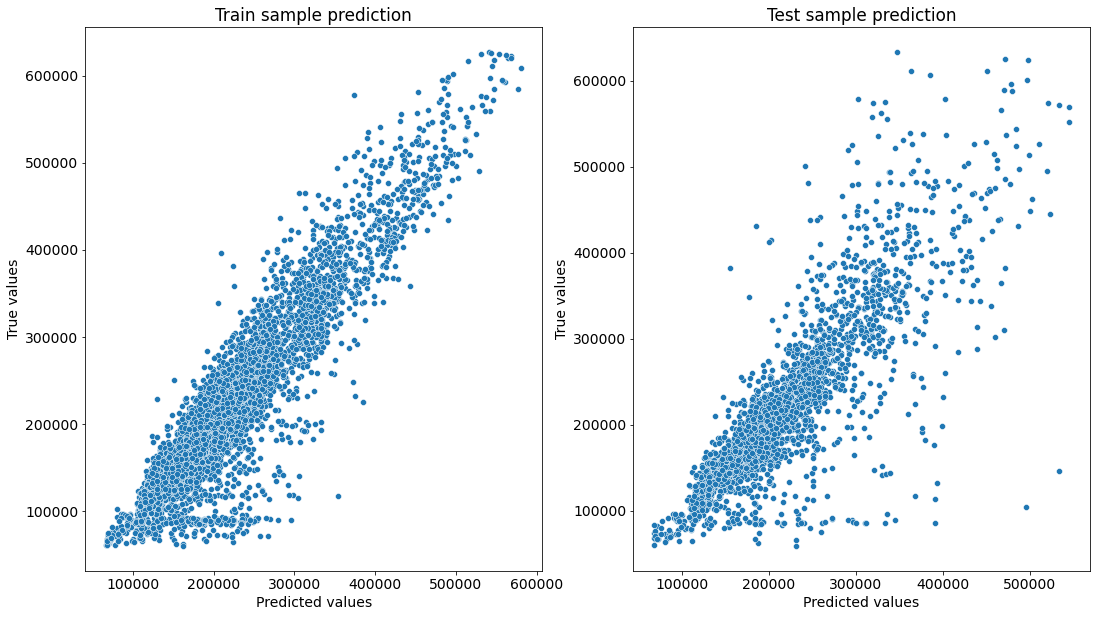

In [37]:
# rf_model = RandomForestRegressor(random_state=42,
#                                 criterion='mse',
#                                 max_depth=9,
#                                 max_features=9,
#                                 n_estimators=400)
# rf_model.fit(X_train, y_train)

# y_train_preds = rf_model.predict(X_train)
# y_test_preds = rf_model.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)
# Train R2:	0.859
# Test R2:	0.713

In [38]:
#Кросс-валидация rf_model
# cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score

array([0.71868334, 0.73590165, 0.78743301])

In [39]:
#Важность признаков rf_model
# feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
#                                    columns=['feature_name', 'importance'])

# feature_importances.sort_values(by='importance', ascending=False).head(3)

,feature_name,importance
23,MedPriceByDistrict,0.423832
1,Square,0.168748
2,LifeSquare,0.093276


##### GradientBoostingRegressor

Train R2:	0.916
Test R2:	0.719


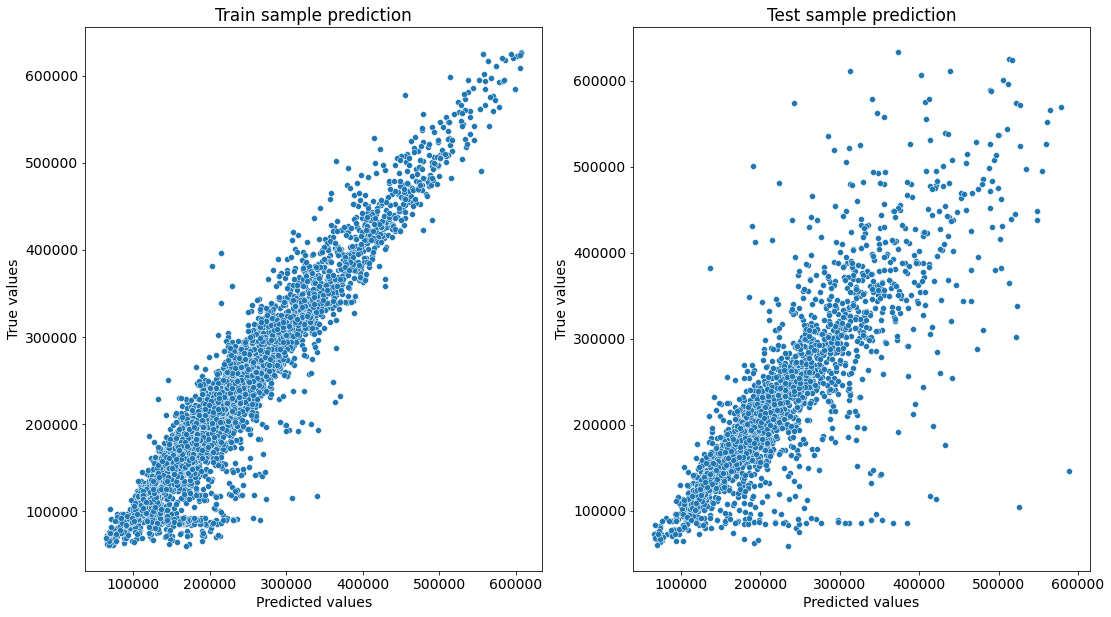

In [40]:
# gb_model = GradientBoostingRegressor(criterion='mse',
#                                      max_depth=7,
#                                      min_samples_leaf=10,
#                                      random_state=42,  
#                                      n_estimators=100)
# gb_model.fit(X_train, y_train)

# y_train_preds = gb_model.predict(X_train)
# y_test_preds = gb_model.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# Train R2:	0.916
# Test R2:	0.719

In [41]:
# Кросс-валидация gb_model
# cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score

array([0.70774192, 0.74585854, 0.78952209])

In [42]:
#Важность признаков gb_model
# feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
#                                    columns=['feature_name', 'importance'])

# feature_importances.sort_values(by='importance', ascending=False).head(3)

,feature_name,importance
23,MedPriceByDistrict,0.689055
1,Square,0.107578
12,Social_3,0.020721


Слишком сильное влияние признака MedPriceByDistrict

##### LGBMRegressor

In [43]:
# parameters = [{
#     'max_bin': np.arange(90, 120, 10),
#     'n_estimators': np.arange(4000, 7000, 1000),
#     'learning_rate': np.arange(0.01, 0.05, 0.01)
# }]

In [44]:
# clf_LGBM = GridSearchCV(
#     estimator=LGBMRegressor(random_state=42),
#     param_grid=parameters,
#     scoring='neg_mean_squared_error',
#     cv=4,
#     n_jobs=-1,
# )
# clf_LGBM.fit(X_train, y_train)
# clf_LGBM.best_params_

{'learning_rate': 0.01, 'max_bin': 90, 'n_estimators': 4000}

Train R2:	0.831
Test R2:	0.718


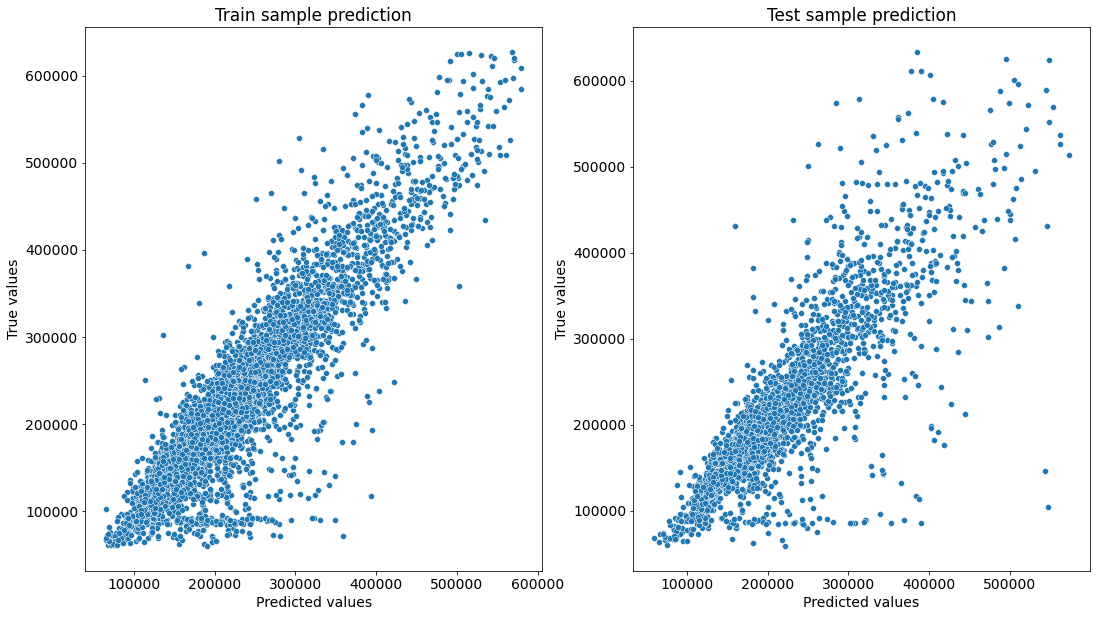

In [45]:
# lgbm_model = LGBMRegressor(
#     max_bin=90,
#     num_leaves=5,
#     n_estimators=4000,
#     learning_rate=0.01
# )
# lgbm_model.fit(X_train, y_train)

# y_train_preds = lgbm_model.predict(X_train)
# y_test_preds = lgbm_model.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# Train R2:	0.831
# Test R2:	0.718

In [46]:
# Кросс-валидация lgbm_model
# cv_score = cross_val_score(lgbm_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score

array([0.71555019, 0.75016722, 0.79635007])

##### CatBoostRegressor

Train R2:	0.867
Test R2:	0.726


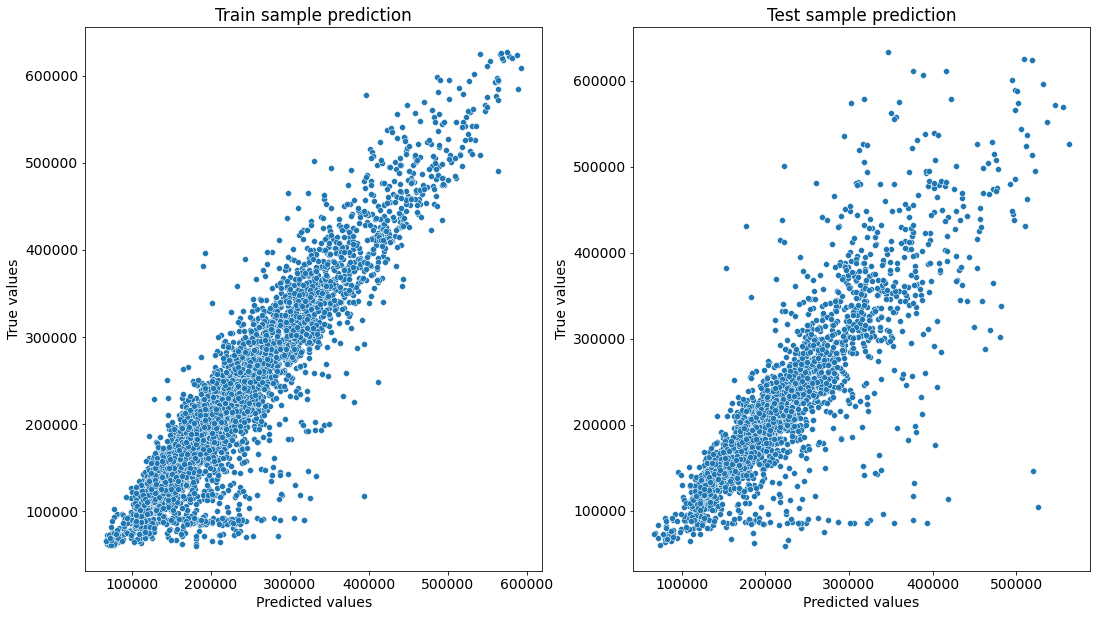

In [48]:
# cb_model = CatBoostRegressor(learning_rate=0.01,
#                             depth=9,
#                             l2_leaf_reg=2,
#                             iterations=1000,
#                             loss_function='RMSE',
#                             eval_metric='R2',
#                             random_seed=42,
#                             silent=True)
# cb_model.fit(X_train, y_train)

# y_train_preds = cb_model.predict(X_train)
# y_test_preds = cb_model.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# Train R2:	0.867
# Test R2:	0.726

In [49]:
# Кросс-валидация cb_model
# cv_score = cross_val_score(cb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score

array([0.73613858, 0.74955841, 0.79708617])

In [50]:
#Важность признаков cb_model
# feature_importances = pd.DataFrame(zip(X_train.columns, cb_model.feature_importances_), 
#                                    columns=['feature_name', 'importance'])

# feature_importances.sort_values(by='importance', ascending=False).head(3)

,feature_name,importance
23,MedPriceByDistrict,29.837029
1,Square,17.545498
21,DistrictSize,5.373743


##### StackingRegressor

#### Ансамбль из CatBoostRegressor и LGBMRegressor

Train R2:	0.86
Test R2:	0.727


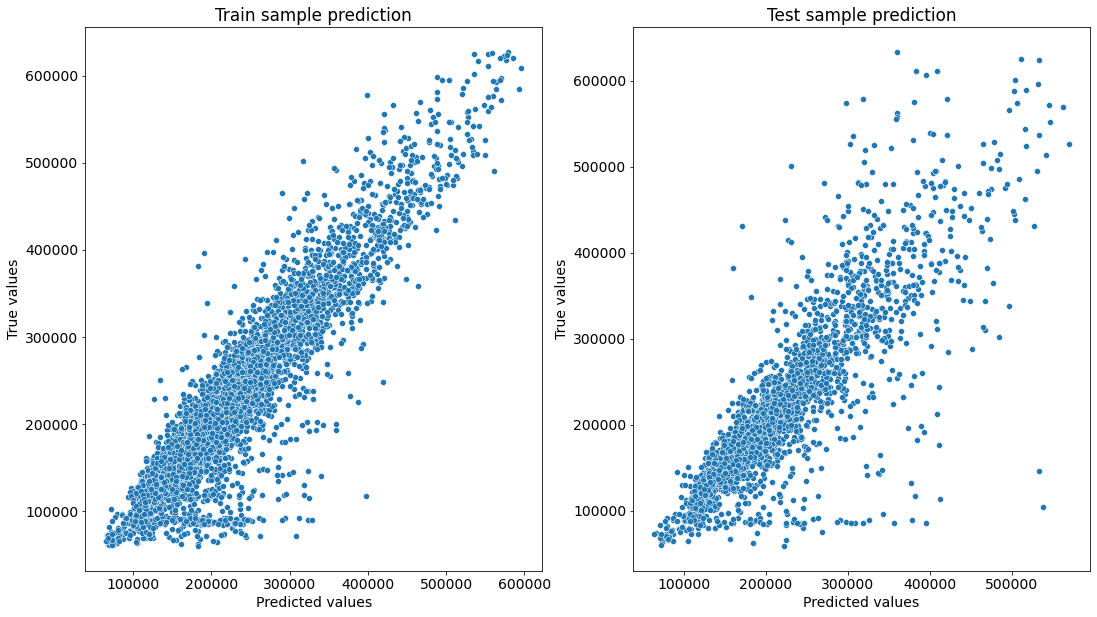

In [51]:
# cb_model = CatBoostRegressor(learning_rate=0.01,
#                             depth=9,
#                             l2_leaf_reg=2,
#                             iterations=1000,
#                             loss_function='RMSE',
#                             eval_metric='R2',
#                             random_seed=42,
#                             silent=True)

# lgbm_model = LGBMRegressor(max_bin=90, num_leaves=5, n_estimators=4000, learning_rate=0.01) 

# stack_final = StackingRegressor([('cb',cb_model), ('lgbm',lgbm_model)])
# stack_final.fit(X_train, y_train)

# y_train_preds = stack_final.predict(X_train)
# y_test_preds = stack_final.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# Train R2:	0.86
# Test R2:	0.727

In [52]:
# Кросс-валидация stack_final
# cv_score = cross_val_score(stack_final, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score

array([0.72999722, 0.75488414, 0.80176161])

#### Ансамбль из RandomForestRegressor и CatBoostRegressor

Train R2:	0.868
Test R2:	0.726


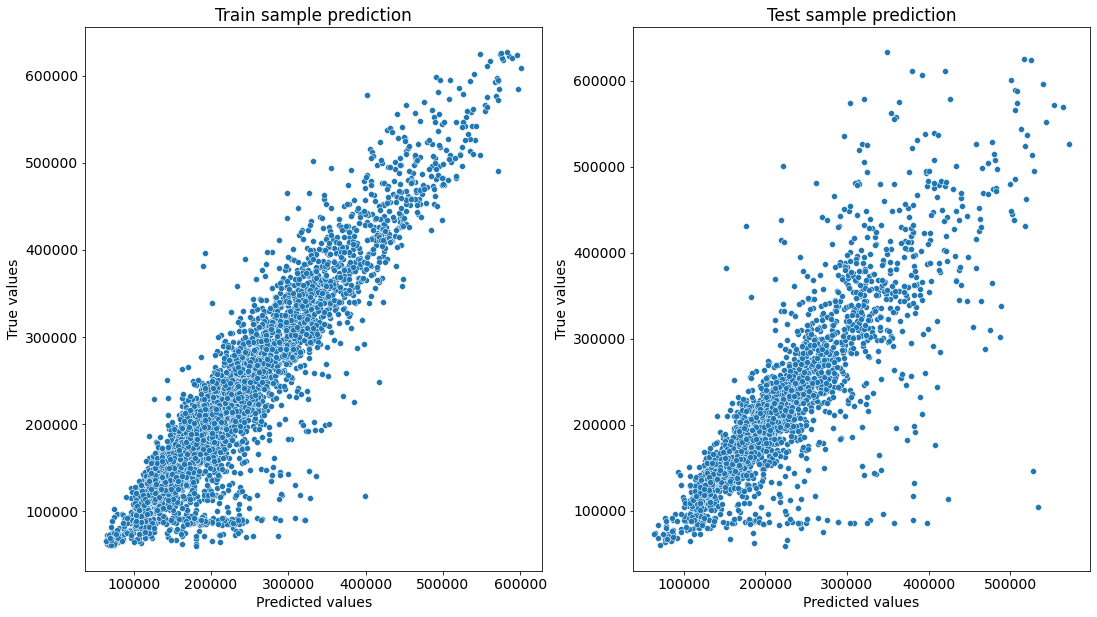

In [54]:
# rf_model = RandomForestRegressor(random_state=42,
#                                 criterion='mse',
#                                 max_depth=9,
#                                 max_features=9,
#                                 n_estimators=400)

# cb_model = CatBoostRegressor(learning_rate=0.01,
#                             depth=9,
#                             l2_leaf_reg=2,
#                             iterations=1000,
#                             loss_function='RMSE',
#                             eval_metric='R2',
#                             random_seed=42,
#                             silent=True)

# stack_final1 = StackingRegressor([('rf',rf_model), ('cb',cb_model)])
# stack_final1.fit(X_train, y_train)

# y_train_preds = stack_final1.predict(X_train)
# y_test_preds = stack_final1.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# Train R2:	0.868
# Test R2:	0.726

In [55]:
# Кросс-валидация stack_final1
# cv_score = cross_val_score(stack_final1, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score

array([0.73250709, 0.75095371, 0.79928402])

#### Ансамбль из RandomForestRegressor и LGBMRegressor

Train R2:	0.849
Test R2:	0.722


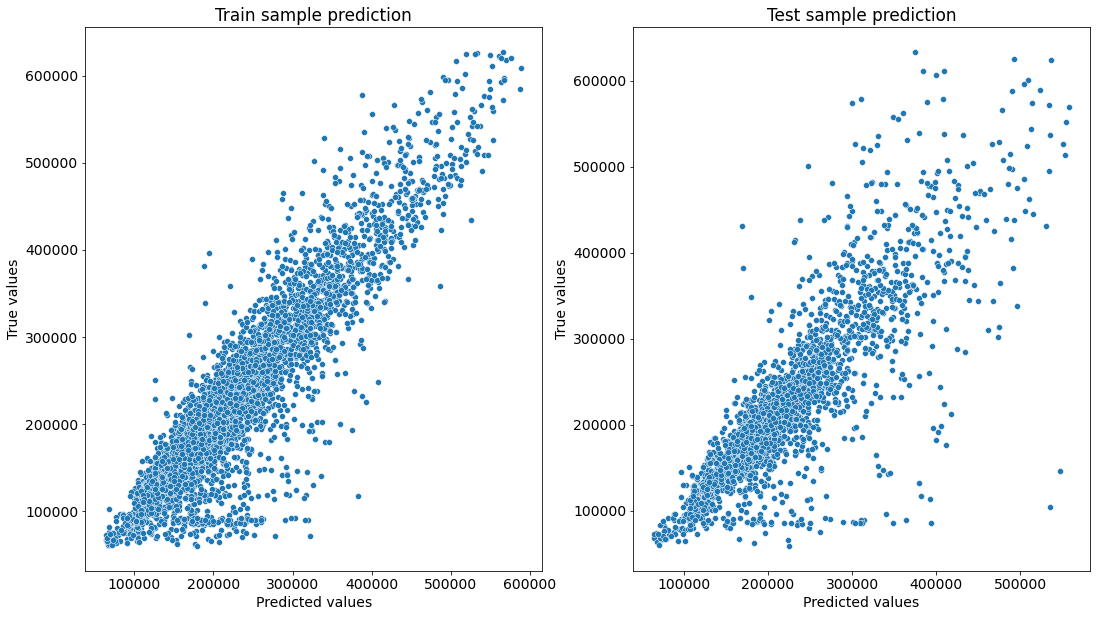

In [57]:
# rf_model = RandomForestRegressor(random_state=42,
#                                 criterion='mse',
#                                 max_depth=9,
#                                 max_features=9,
#                                 n_estimators=400)

# lgbm_model = LGBMRegressor(max_bin=90, num_leaves=5, n_estimators=4000, learning_rate=0.01) 

# stack_final2 = StackingRegressor([('rf',rf_model), ('lgbm',lgbm_model)])
# stack_final2.fit(X_train, y_train)

# y_train_preds = stack_final2.predict(X_train)
# y_test_preds = stack_final2.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# Train R2:	0.849
# Test R2:	0.722

In [58]:
# Кросс-валидация stack_final2
# cv_score = cross_val_score(stack_final2, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
# cv_score

array([0.72154022, 0.75119218, 0.80034295])

### 7. Прогнозирование на тестовом датасете 

In [67]:
test_df.shape

(5000, 25)

In [68]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Square_outlier,DistrictSize,new_district,MedPriceByDistrict,MedPriceByFloorYear
0,1.0,36.847630,23.115885,5.0,5,9.0,1970,0.036122,1,1,...,1,1,0,0,0,0,76.0,0,171145.169069,190373.748195
1,1.0,42.493907,26.658004,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,0,169.0,0,130720.196859,181580.024287
2,2.0,59.463678,32.925087,9.0,19,19.0,1977,0.211401,1,1,...,1,1,0,0,0,0,609.0,0,165993.292450,185822.044093
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,1,0,0,0,0,392.0,0,169121.013931,190373.748195
4,1.0,53.837056,32.925087,6.0,8,17.0,1977,0.309479,1,1,...,6,1,0,0,0,0,68.0,0,164116.183543,189090.882477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,6,6.0,1962,0.069660,1,1,...,2,1,0,1,0,0,59.0,0,183575.963167,194529.785764
4996,3.0,93.698122,58.780307,10.0,21,27.0,2018,0.060753,1,1,...,7,1,0,0,0,0,26.0,0,425037.641820,273063.467909
4997,1.0,33.656723,21.114111,5.0,2,5.0,1966,0.038693,1,1,...,5,1,0,0,0,0,57.0,0,154030.205137,190373.748195
4998,1.0,38.635155,24.237266,9.0,8,14.0,1970,0.089040,1,1,...,11,1,0,0,0,0,42.0,0,177482.263846,194529.785764


In [69]:
submit = pd.read_csv(SUBMIT_DATASET_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [70]:
predictions = stack_final.predict(test_df)
predictions

array([157975.5691261 , 119533.98740019, 154038.92429853, ...,
       141158.53125604, 185903.70440745, 261519.43107233])

In [71]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,157975.569126
1,5925,119533.987400
2,960,154038.924299
3,3848,118984.767652
4,746,172198.064158


In [72]:
submit.to_csv('submit_final.csv', index=False)